#  Core Sequence-Aware Agent Design v2

This experiment explores a transformer-based recurrent PPO agent for financial trading. The environment is sequence-aware and includes both regime-based augmentation and per-episode reward normalization. The agent is evaluated across top 2 stocks in each sector using structured episode sequences to assess learning generalization.

---

##  Experiment Configuration

| Parameter               | Value                         |
|-------------------------|-------------------------------|
| Agent                   | Recurrent PPO + Transformer   |
| Env Wrapper             | RegimeAugmentingWrapper + PerEpisodeRewardNormalizer |
| Episode Length          | 100                           |
| Episodes                | 20                            |
| Eval Episodes           | 3 per iteration               |
| Steps per Update        | 800                           |
| Batch Size              | 100                           |
| Total Timesteps         | 20,000                        |
| Learning Rate           | 0.0003                        |
| Entropy Coefficient     | 0.005                         |
| Value Function Coeff    | 0.5                           |
| Max Gradient Norm       | 0.5                           |
| Normalize Advantage     | True                          |
| Optimizer               | Adam                          |
| Transformer d_model     | 64                            |
| Heads                  | 4                             |
| Layers                 | 2                             |

---

## Environment Setup

- **Train Set:** 2023-01-01 → 2023-07-01
- **Test Set:** 2023-07-01 → 2024-01-01
- **Assets:** Top 2 stocks by sector
- **Sequence Split:** 80% train / 20% eval sequences

---

##  Agent Architecture

- **Feature Extractor:** Transformer encoder with causal mask and learnable positional encoding.
- **Policy Class:** Custom `TransformerPolicy` extending `RecurrentActorCriticPolicy`.
- **Reward Normalization:** Online normalization within episodes.
- **Regime Augmentation:** Appends one-hot encoded market regime to each timestep.

---

## Training Summary (Selected Stats)

| Timesteps | Ep Rew Mean | Explained Variance | Value Loss | Policy Grad Loss |
|-----------|-------------|--------------------|------------|------------------|
|  8000     | 3.21        | 0.15               | 4.68       | -0.00277         |
| 14400     | 2.90        | 0.645              | 1.71       |  0.00163         |
| 20000     | **3.79**    | **0.751**          | 1.59       | -0.00012         |

---

## Evaluation Snapshots

| Timestep | Mean Reward | Std Dev | Eval Length |
|----------|-------------|---------|-------------|
| 5000     | -8.17       | ±8.72   | 102         |
| 10000    | -4.43       | ±7.59   | 102         |
| 15000    | -6.17       | ±4.92   | 102         |
| 20000    | **0.24**    | ±2.86   | 102         |

---

## Statistical Significance

### Paired t-test and Mann-Whitney U-test

| Metric       | t-test p-value | Mann-Whitney p-value |
|--------------|----------------|-----------------------|
| `total_reward` | 0.0300         | 0.0075                |
| `calmar`       | 0.0132         | 0.0075                |

✅ Both `total_reward` and `calmar ratio` show **statistically significant** improvements compared to the baseline.  
Especially, Calmar implies **more stable and risk-adjusted returns**.

> Note: `sharpe`, `sortino`, and `final_wealth` were skipped due to empty values in the evaluation logs. Ensure metrics are logged and valid across all test episodes to include them.

---

## Next Steps

1. **Fix missing metrics** (`sharpe`, `sortino`, etc.) in the logging pipeline.
2. **Plot distribution comparisons** (boxplots, histograms) for rewards and risk-adjusted returns.
3. **Run ablation**:
   - Without regime augmentation
   - Without reward normalization
   - With simpler agents (e.g., MLP or LSTM)
4. **Test in unseen market conditions** or during volatility spikes to check robustness.

---

_Logged using `ExperimentTracker` — Run Hash: `${experiment_tracker.run_hash}`_


In [1]:
# SETUP ===================================
import jupyter
import warnings

from src.utils.system import boot, Notify

boot()
warnings.filterwarnings("ignore")



# PACKAGES ================================
import os
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import gymnasium as gym
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import  RobustScaler

# FRAMEWORK STUFF =========================
from src.defaults import TOP2_STOCK_BY_SECTOR, FEATURE_COLS,EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
from src.experiments.experiment_tracker import ExperimentTracker
from src.env.base_timeseries_trading_env import BaseSequenceAwareTradingEnv,SequenceAwareAlphaTradingEnv,SequenceAwareBaselineTradingAgent,SequenceAwareCalmarTradingEnv,SequenceAwareCumulativeTradingEnv,SequenceAwareDrawdownTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareHybridTradingEnv,SequenceAwareSharpeTradingEnv,SequenceAwareSortinoTradingEnv

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy



In [2]:

# ========== CONFIG ==========
EXPERIENCE_NAME = "core_sequence_aware_agent_design_v2"
RESULTS_PATH = f"data/experiments/{EXPERIENCE_NAME}_barebones_results.csv"
N_EPISODES = 20
N_SEEDS = 3
N_EVAL_EPISODES = 3

WINDOW_LENGTH = 10  
TOTAL_TIMESTEPS = EPISODE_LENGTH * 150
N_STEPS = EPISODE_LENGTH * 2

TRANSACTION_COST = 0

CONFIG = {
    "batch_size": EPISODE_LENGTH,
    "n_steps": 800,
    "total_timesteps": TOTAL_TIMESTEPS,
    "project_name":EXPERIENCE_NAME
}




# Load data ==================================
ohlcv_df = load_base_dataframe()

# Experiment tracker ========================= 
experiment_tracker = ExperimentTracker(EXPERIENCE_NAME)
experiment_tracker.set_hash(CONFIG)

# Files ======================================
checkpoint_path = "data/checkpoint" 
checkpoint_name = "-8377624099423380081"#experiment_tracker.run_hash
checkpoint_preffix = f"{checkpoint_name}--checkpoint"
checkpoint_best_model=f"{checkpoint_path}/{checkpoint_name}--best_model"
log_path="data/logs"
save_path= f"{checkpoint_path}/{checkpoint_name}--final"
print(checkpoint_name)
#data/checkpoint/-8377624099423380081--final
#data/checkpoint/-3848392742194634112--best_model

-8377624099423380081


In [3]:
EPISODE_LENGTH = 100
MAX_LENGTH = 200
SAVE_FREQ=10000
EVAL_FREQ=5000
TOTAL_TIMESTEPS=200000
#TOTAL_TIMESTEPS=1000
EPISODES_PER_UPDATE = 8          # ~how many episodes before PPO updates
EPISODES_PER_BATCH = 1           # number of full episodes per batch

# === Auto-derive PPO settings ===
N_STEPS = EPISODE_LENGTH * EPISODES_PER_UPDATE
BATCH_SIZE = EPISODE_LENGTH * EPISODES_PER_BATCH

ENV_CLASS = SequenceAwareCumulativeTradingEnv

n = Notify(experiment_tracker.project)
n.info('START')
print(N_STEPS,BATCH_SIZE)

800 100


In [4]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy

# Causal Mask Function ============================
def generate_causal_mask(seq_len):
    return torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool), diagonal=1)

# Transformer Feature Extractor ===================
class TransformerFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, d_model=64, n_heads=4, n_layers=2, max_len=MAX_LENGTH):
        super().__init__(observation_space, features_dim=d_model)
        self.d_model = d_model
        input_dim = observation_space.shape[-1]

        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward_v1(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]
        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)
        return x[:, -1]  # return the last token output
    
    def forward(self, obs):
        # obs shape: (batch, seq_len, input_dim)
        #print(">>> [Transformer] Input shape:", obs.shape)

        x = self.input_proj(obs)
        seq_len = x.size(1)
        x = x + self.positional_encoding[:seq_len]

        causal_mask = generate_causal_mask(seq_len).to(x.device)
        x = self.transformer(x, mask=causal_mask)

        pooled_output = x[:, -1]
        #print(">>> [Transformer] Pooled output mean/std:", pooled_output.mean().item(), pooled_output.std().item())

        return pooled_output

# Transformer Policy ===================================
class TransformerPolicy(RecurrentActorCriticPolicy):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs,
                         features_extractor_class=TransformerFeatureExtractor,
                         features_extractor_kwargs=dict(
                             d_model=64, n_heads=4, n_layers=2, max_len=32
                         ))
        #self._build(self.lr_schedule)

# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # 0,1,2 -> bull,bear,sideways
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

class PerEpisodeRewardNormalizer(gym.Wrapper):
    def reset(self, **kwargs):
        self.episode_rewards = []
        return self.env.reset(**kwargs)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.episode_rewards.append(reward)
        mean = np.mean(self.episode_rewards)
        std = np.std(self.episode_rewards) + 1e-8
        norm_reward = (reward - mean) / std
        return obs, norm_reward, done, truncated, info
# Training =============================================================
train_df = ohlcv_df[(ohlcv_df['date']>="2023-01-01") & (ohlcv_df['date']<"2023-07-01")]
test_df = ohlcv_df[(ohlcv_df['date']>="2023-07-01") & (ohlcv_df['date']<"2024-01-01")]
train_df = train_df[train_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]

train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
test_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
# Train on few episodes to prove a point only
train_seq = train_env.generate_episode_sequences(TOTAL_TIMESTEPS)
_test_seq = test_env.generate_episode_sequences(int(TOTAL_TIMESTEPS))
episodes = _test_seq
unique_episodes = {}
for ticker, start in episodes:
    if ticker not in unique_episodes:
        unique_episodes[ticker] = start
# Convert back to a list of tuples
test_seq = [(ticker, start) for ticker, start in unique_episodes.items()]

print(f"Training on {len(train_seq)} different episodes accross the top 2 stocks for each sector")
print(f"Testing on {len(test_seq)} different episodes accross the top 2 stocks for each sector")
def train_agent():
    
    
    
    train_env =ENV_CLASS(train_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    train_env.set_episode_sequence(train_seq)
    eval_env.set_episode_sequence(test_seq)
    
    train_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(train_env))
    eval_env = PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env))
    checkpoint_callback = CheckpointCallback(
        save_freq=SAVE_FREQ, save_path=checkpoint_path, name_prefix=checkpoint_preffix
    )

    eval_callback = EvalCallback(
        eval_env, best_model_save_path=checkpoint_best_model,
        log_path=log_path, eval_freq=EVAL_FREQ, deterministic=True
    )

    model = RecurrentPPO(
        policy=TransformerPolicy,
        env=train_env,
        verbose=1,
        #tensorboard_log="./tensorboard_logs",
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        learning_rate=3e-4,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=0.005,
        vf_coef=0.5,
        max_grad_norm=0.5,
        normalize_advantage=True,
        policy_kwargs=dict(share_features_extractor=True)
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback, eval_callback])
    model.save(save_path)

#if __name__ == "__main__":
#    train_agent()


Training on 1961 different episodes accross the top 2 stocks for each sector
Testing on 22 different episodes accross the top 2 stocks for each sector


In [5]:
n = Notify(experiment_tracker.project)
n.info('DONE')

In [230]:
import random
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces


from src.env.step_rewards import reward_sharpe,reward_sortino,reward_drawdown,reward_alpha,reward_cumulative,reward_calmar,reward_hybrid

class BaseSequenceAwareTradingEnv(gym.Env):
    """
    Flexible RL Trading Env with windowed sequence obs (Transformer/LSTM/MLP-ready).
    - Set `return_sequences=True` for (window_length, obs_dim) obs (for transformers).
    - Set `return_sequences=False` for flat obs (classic RL, SB3 LSTM/MLP).
    """
    metadata = {"render_modes": ["human"]}

    def __init__(
        self, df, feature_cols=None, reward_fn=None, internal_features=None,
        episode_length=100, transaction_cost=0.0001, seed=314, window_length=10, return_sequences=True):
        super().__init__()
        self.df = df.copy()
        self.feature_cols = feature_cols or []
        self.internal_features = internal_features or [
            "position", "holding_period", "cumulative_reward", "pct_time",
            "drawdown", "rel_perf", "unrealized_pnl", "entry_price", "time_in_position"
        ]
        self.obs_dim = len(self.feature_cols) + len(self.internal_features)
        self.episode_length = episode_length +2
        self.window_length = max(1, window_length)
        self.return_sequences = return_sequences  # True: (window, obs_dim), False: flat
        self.transaction_cost = transaction_cost
        self.seed = seed
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if seed is not None:
            np.random.seed(seed)
        counts = df['symbol'].value_counts()
        eligible = counts[counts >= episode_length].index
        self.stocks = df[df['symbol'].isin(eligible)]['symbol'].unique()
        self.episode_df = df.copy()
        self.reward_fn = reward_fn or self.default_reward_fn

        # Set observation space
        if self.return_sequences:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length, self.obs_dim), dtype=np.float32
            )
        else:
            self.observation_space = spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(self.window_length * self.obs_dim,), dtype=np.float32
            )
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell

    
    def get_current_regime(self):
        """
        Detects current regime based on recent return volatility and trend.
        Returns:
            0 = Bull, 1 = Bear, 2 = Sideways
        """
        if self.current_step < self.window_length:
            return 2  # Not enough data, assume sideways

        # Use recent price changes to detect regime
        returns = self.episode_df['return_1d'].iloc[self.current_step - self.window_length:self.current_step].values
        mean_return = returns.mean()
        std_return = returns.std()

        # Thresholds can be tuned
        if mean_return > 0.001 and std_return < 0.01:
            return 0  # Bull
        elif mean_return < -0.001 and std_return < 0.01:
            return 1  # Bear
        else:
            return 2  # Sideways
        
    def default_reward_fn(self, position, price_change, **kwargs):
        return position * price_change

    def set_episode_sequence(self, sequence):
        self.episode_sequence = sequence
        self.episode_counter = 0

    def generate_episode_sequences_v1(self, train_steps=10000):
        dataset_length = len(self.df)
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        ticker = self.df['symbol'].unique()[0]
        min_start = 0
        max_start = dataset_length - self.episode_length - 2
        for i in range(episodes):
            episode_sequences.append((ticker, np.random.randint(0, max_start)))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def generate_episode_sequences(self, train_steps=10000):
        episodes = int(train_steps / self.episode_length) + 1
        episode_sequences = []
        for _ in range(episodes):
            ticker = np.random.choice(self.stocks)
            stock_df = self.df[self.df['symbol'] == ticker].reset_index(drop=True)
            max_start = len(stock_df) - self.episode_length - 2
            if max_start <= 0:
                continue  # skip if not enough data
            start = np.random.randint(0, max_start)
            episode_sequences.append((ticker, start))
        np.random.shuffle(episode_sequences)
        return episode_sequences

    def reset(self, seed=None, options=None, start_index=None):
        self.entry_step = None
        self.unrealized_pnl = 0
        self.relative_perf = 0
        self.drawdown = 0
        self.time_in_position = 0
        self.action_counts = {0: 0, 1: 0, 2: 0}  # Hold, Buy, Sell
        if self.seed is not None:
            np.random.seed(self.seed)
            
            
        symbol, start_idx = self.episode_sequence[self.episode_counter]
        print(symbol,start_idx,self.df['symbol'].unique())
        symbol_df = self.df[self.df['symbol'] == symbol].reset_index(drop=True)
        print(len(symbol_df))
        
        if start_idx + self.episode_length > len(symbol_df):
            print(f"[WARN] Episode too short for {symbol} at {start_idx}, skipping...")
            self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
            return self.reset()  # tenta o próximo episódio

        # ✅ Extração segura
        #self.episode_df = symbol_df.iloc[start_idx : start_idx + self.episode_length].copy()
        end = start_idx + self.episode_length + 1
        if end > len(symbol_df):
            print(f"[WARN] Not enough data for {symbol} from {start_idx}, skipping.")
            self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
            return self.reset()
        self.episode_df = symbol_df.iloc[start_idx:end].copy()
        

        # Move to next episode (with wrap-around)
        self.episode_counter = (self.episode_counter + 1) % len(self.episode_sequence)
        """
        for _ in range(10):  # Try up to 10 times to get a valid episode
            stock = self.stocks[0]
            if hasattr(self, "episode_sequence"):
                if self.episode_counter >= len(self.episode_sequence):
                    self.episode_counter = 0
                _, start = self.episode_sequence[self.episode_counter]
                self.episode_counter += 1
            else:
                stock = np.random.choice(self.stocks)
                stock_df = self.df[self.df['symbol'] == stock].reset_index(drop=True)
                max_start = len(stock_df) - self.episode_length
                if max_start <= 0:
                    continue  # Try another stock
                start = np.random.randint(0, max_start + 1)

            self.stock = stock
            stock_df = self.df[self.df['symbol'] == self.stock].reset_index(drop=True)
            self.episode_df = stock_df.iloc[int(start):int(start) + int(self.episode_length + 2)].reset_index(drop=True)

            if len(self.episode_df) >= self.window_length:
                break
        else:
            raise RuntimeError("Failed to sample a valid episode with sufficient data.")
        """
        self.current_step = 0
        self.entry_price = None
        self.position = 0
        self.holding_period = 0
        self.cumulative_reward = 0
        self.returns_history = []
        self.reward_history = []
        self.episode_pct_changes = self.episode_df['return_1d'].values
        self.max_possible_reward = np.sum(np.abs(self.episode_pct_changes))
        self.current_wealth = 1.0
        self.peak_wealth = 1.0

        return self._get_obs(), {}

    def _get_obs(self):
        # Returns a rolling window of observations (2D or flattened)
        obs_list = []
        #for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
        #    idx = max(i, 0)  # pad with earliest available step
        #    features = self.episode_df.iloc[idx][self.feature_cols].values.astype(np.float32)
        for i in range(self.current_step - self.window_length + 1, self.current_step + 1):
            if 0 <= i < len(self.episode_df):
                features = self.episode_df.iloc[i][self.feature_cols].values.astype(np.float32)
            else:
                features = np.zeros(len(self.feature_cols), dtype=np.float32)  # zero padding
            internal_state = {
                "position": self.position,
                "holding_period": self.holding_period,
                "cumulative_reward": self.cumulative_reward,
                "pct_time": self.current_step / self.episode_length,
                "drawdown": self.drawdown,
                "rel_perf": self.relative_perf,
                "unrealized_pnl": self.unrealized_pnl,
                "entry_price": self.entry_price if self.entry_price is not None else 0.0,
                "time_in_position": self.time_in_position,
            }
            internal = np.array([internal_state[name] for name in self.internal_features], dtype=np.float32)
            obs = np.concatenate([features, internal])
            obs_list.append(obs)
        obs_window = np.stack(obs_list)  # shape: (window_length, obs_dim)
        if self.return_sequences:
            return obs_window  # shape: (window_length, obs_dim)
        else:
            return obs_window.flatten()  # shape: (window_length * obs_dim,)
        
    

    def step(self, action):
        #print(self.current_step,self.episode_length,len(self.episode_df))
        done = self.current_step >= self.episode_length - 1
        current_row = self.episode_df.iloc[self.current_step]

        # Protege contra acesso fora dos limites
        if self.current_step + 1 < len(self.episode_df):
            next_row = self.episode_df.iloc[self.current_step + 1]
        else:
            next_row = current_row.copy()  # fallback seguro

        price_change = next_row['return_1d']
        prev_position = self.position
        reward = 0
        cost = 0

        self.action_counts[action] += 1

        if action == 1:  # Buy
            if self.position != 1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = 1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        elif action == 2:  # Sell
            if self.position != -1:
                if self.position != 0:
                    cost = self.transaction_cost
                self.position = -1
                self.holding_period = 0
                self.entry_price = current_row['close']
                self.entry_step = self.current_step

        if self.position != 0:
            self.holding_period += 1

        step_return = self.position * price_change
        self.returns_history.append(step_return)
        self.current_wealth *= (1 + step_return)
        if self.current_wealth > self.peak_wealth:
            self.peak_wealth = self.current_wealth
        self.drawdown = 1 - self.current_wealth / self.peak_wealth

        if self.position != 0 and self.entry_price is not None:
            current_price = next_row['close']
            self.unrealized_pnl = (current_price - self.entry_price) * self.position / self.entry_price
            self.time_in_position = self.current_step - self.entry_step
        else:
            self.unrealized_pnl = 0
            self.time_in_position = 0

        if 'market_return_1d' in self.episode_df.columns:
            self.relative_perf = price_change - next_row['market_return_1d']
        else:
            self.relative_perf = 0

        reward = self.reward_fn(
            position=self.position,
            price_change=price_change,
            prev_position=prev_position,
            env=self
        )
        reward -= cost
        self.reward_history.append(reward)
        self.cumulative_reward += reward

        self.current_step += 1
        obs = self._get_obs()
        info = {}
        info["regime"] = self.get_current_regime()

        # Calcula métricas no final do episódio
        if done:
            returns = np.array(self.returns_history)
            mean = np.median(returns) if len(returns) > 0 else np.nan
            std = returns.std() if len(returns) > 1 else np.nan
            downside = returns[returns < 0]
            downside_std = downside.std() if len(downside) > 1 else np.nan

            sharpe = mean / std if (std is not None and std > 0 and not np.isnan(std)) else np.nan
            sortino = mean / downside_std if (downside_std is not None and downside_std > 0 and not np.isnan(downside_std)) else np.nan

            wealth_curve = np.cumprod(1 + returns) if len(returns) > 0 else np.array([])
            peak_wealth = np.maximum.accumulate(wealth_curve) if len(wealth_curve) > 0 else np.array([])
            drawdowns = (wealth_curve - peak_wealth) / (peak_wealth + 1e-8) if len(wealth_curve) > 0 else np.array([])
            max_drawdown = np.abs(drawdowns.min()) if len(drawdowns) > 0 else np.nan
            calmar = ((wealth_curve[-1] - 1) / max_drawdown) if (len(wealth_curve) > 0 and max_drawdown and not np.isnan(max_drawdown) and max_drawdown > 0) else np.nan
            cum_return = wealth_curve[-1] - 1 if len(wealth_curve) > 0 else np.nan
            final_wealth = wealth_curve[-1] if len(wealth_curve) > 0 else np.nan

            # Trade-level metrics
            trades = []
            trade_profits = []
            prev = 0
            for i, ret in enumerate(returns):
                if prev == 0 and ret != 0:
                    entry_idx = i
                    entry_dir = np.sign(ret)
                elif prev != 0 and (ret == 0 or np.sign(ret) != np.sign(prev)):
                    if 'entry_idx' in locals():
                        trade = returns[entry_idx:i+1]
                        trade_profits.append(np.sum(trade))
                        del entry_idx
                prev = ret
            win_rate = np.median(np.array(trade_profits) > 0) if trade_profits else np.nan

            if 'market_return_1d' in self.episode_df.columns:
                market_returns = self.episode_df['market_return_1d'].values[1:self.episode_length]
                market_wealth_curve = np.cumprod(1 + market_returns) if len(market_returns) > 0 else np.array([])
                market_cum_return = market_wealth_curve[-1] - 1 if len(market_wealth_curve) > 0 else np.nan
                alpha = cum_return - market_cum_return if cum_return is not None and not np.isnan(cum_return) and market_cum_return is not None and not np.isnan(market_cum_return) else np.nan
            else:
                alpha = np.nan

            info.update({
                "episode_sharpe": sharpe,
                "episode_sortino": sortino,
                "episode_total_reward": np.sum(self.reward_history) if len(self.reward_history) > 0 else np.nan,
                "cumulative_return": cum_return,
                "calmar": calmar,
                "max_drawdown": max_drawdown,
                "win_rate": win_rate,
                "alpha": alpha,
                "returns": returns,
                "market_returns": market_returns if 'market_returns' in locals() else [],
                "downside": downside,
                "regime": self.get_current_regime(),
                "final_wealth": final_wealth,
                "action_hold_count": self.action_counts[0],
                "action_buy_count": self.action_counts[1],
                "action_sell_count": self.action_counts[2]
            })

        return obs, reward, done, False, info

    def render(self):
        print(f"Step: {self.current_step} | Pos: {self.position} | Hold: {self.holding_period} | CumRew: {self.cumulative_reward:.4f}")



class SequenceAwareSharpeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sharpe, **kwargs)

class SequenceAwareSortinoTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_sortino, **kwargs)

class SequenceAwareAlphaTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_alpha, **kwargs)

class SequenceAwareDrawdownTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_drawdown, **kwargs)

class SequenceAwareCumulativeTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_cumulative, **kwargs)

class SequenceAwareCalmarTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_calmar, **kwargs)

class SequenceAwareHybridTradingEnv(BaseSequenceAwareTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, reward_fn=reward_hybrid, **kwargs)

class SequenceAwareBaselineTradingAgent:
    def __init__(self,df,feature_cols=[],
            episode_length=100, seed=314,set_episode_sequence=[]):
    
        self.env = BaseSequenceAwareTradingEnv(df, feature_cols=feature_cols,
            episode_length=episode_length, seed=seed)
        self.env.set_episode_sequence(set_episode_sequence)
        
    def predict(self,obs,*args,**kwargs):
        #print(self.env.stocks,'xxxxxxxxxxx')
        return self.env.action_space.sample(),{}
    
    def set_episode_sequence(self,seq):
        
        pass

    
    
# Regime Augmentation Wrapper ===========================
class RegimeAugmentingWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.regime_dim = 3  # One-hot: bull, bear, sideways
        obs_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(obs_shape[0], obs_shape[1] + self.regime_dim),
            dtype=np.float32
        )

    def observation(self, obs):
        regime = self.env.get_current_regime()  # should return 0, 1, or 2
        one_hot = np.zeros(self.regime_dim)
        one_hot[regime] = 1.0
        one_hot = np.repeat(one_hot[None, :], obs.shape[0], axis=0)
        return np.concatenate([obs, one_hot], axis=-1)

In [231]:
class MarketVersusWalletHistoryTracker:
    def __init__(self, initial_wallet=1.0):
        self.wallet_value = initial_wallet
        self.prev_wallet_value = initial_wallet
        self.wallet_locked = False
        self.buy_price = None
        self.market_entry_price = None
        self.last_price = None
        self.has_opened_position = False  # NEW: ensure proper update after first buy

        self.wallet_history = []
        self.market_history = []
        self.price_history = []
        self.action_history = []

    def reset(self, initial_price):
        self.__init__(initial_wallet=1.0)
        self.market_entry_price = initial_price
        self.last_price = initial_price
        self.wallet_history.append(self.wallet_value)
        self.market_history.append(1.0)
        self.price_history.append(initial_price)
        self.action_history.append(0)

    def step(self, action, current_price):
        self.price_history.append(current_price)
        agent_action = 0

        # === 1. Update market benchmark ===
        market_perf = current_price / self.market_entry_price
        self.market_history.append(market_perf)

        # === 2. Update wallet value ===
        if self.wallet_locked and self.has_opened_position:
            self.wallet_value *= current_price / self.last_price

        self.wallet_history.append(self.wallet_value)
        self.prev_wallet_value = self.wallet_value
        self.last_price = current_price  # must be set after wallet update!

        # === 3. Process Action ===
        if action == 1 and not self.wallet_locked:
            self.buy_price = current_price
            self.wallet_locked = True
            self.has_opened_position = True
            agent_action = 1

        elif action == 2 and self.wallet_locked:
            self.wallet_locked = False
            self.buy_price = None
            self.has_opened_position = False
            agent_action = 2

        self.action_history.append(agent_action)

    def export(self):
        return {
            "wallet_history": self.wallet_history,
            "market_history": self.market_history,
            "market_price_history": self.price_history,
            "performed_action_history": self.action_history
        }


Evaluating Agent:   0%|          | 0/22 [00:00<?, ?it/s]

LIN 4 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78

Evaluating Agent:   5%|▍         | 1/22 [00:00<00:17,  1.23it/s]

81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
SO 10 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103


Evaluating Agent:   9%|▉         | 2/22 [00:01<00:16,  1.22it/s]

85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
LLY 11 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103

Evaluating Agent:  14%|█▎        | 3/22 [00:02<00:15,  1.24it/s]

92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
JPM 3 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103


Evaluating Agent:  18%|█▊        | 4/22 [00:03<00:14,  1.26it/s]

76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
COST 2 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103

Evaluating Agent:  23%|██▎       | 5/22 [00:03<00:13,  1.30it/s]

91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
NEE 2 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103


Evaluating Agent:  27%|██▋       | 6/22 [00:04<00:11,  1.38it/s]

94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
GE 11 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103


Evaluating Agent:  32%|███▏      | 7/22 [00:05<00:10,  1.42it/s]

92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
UBER 7 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103

Evaluating Agent:  36%|███▋      | 8/22 [00:05<00:09,  1.46it/s]

92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
AMZN 0 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103

Evaluating Agent:  41%|████      | 9/22 [00:06<00:08,  1.46it/s]

84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
META 6 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103

Evaluating Agent:  45%|████▌     | 10/22 [00:07<00:08,  1.46it/s]

81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
MSFT 16 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 10

Evaluating Agent:  50%|█████     | 11/22 [00:07<00:07,  1.45it/s]

72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
XOM 6 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103


Evaluating Agent:  55%|█████▍    | 12/22 [00:08<00:06,  1.45it/s]

94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
V 20 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
7

Evaluating Agent:  59%|█████▉    | 13/22 [00:09<00:06,  1.45it/s]

91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
TSLA 17 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 10

Evaluating Agent:  64%|██████▎   | 14/22 [00:09<00:05,  1.47it/s]

85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
GOOGL 4 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 10

Evaluating Agent:  68%|██████▊   | 15/22 [00:10<00:04,  1.46it/s]

77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
AMT 7 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103


Evaluating Agent:  73%|███████▎  | 16/22 [00:11<00:04,  1.44it/s]

73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
UNH 16 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103

Evaluating Agent:  77%|███████▋  | 17/22 [00:12<00:03,  1.45it/s]

97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
CVX 5 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103


Evaluating Agent:  82%|████████▏ | 18/22 [00:12<00:02,  1.42it/s]

83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
PLD 5 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103


Evaluating Agent:  86%|████████▋ | 19/22 [00:13<00:02,  1.42it/s]

76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
WMT 2 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103


Evaluating Agent:  91%|█████████ | 20/22 [00:14<00:01,  1.43it/s]

SHW 6 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78

Evaluating Agent:  95%|█████████▌| 21/22 [00:14<00:00,  1.43it/s]

94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
AAPL 11 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 10

Evaluating Agent: 100%|██████████| 22/22 [00:15<00:00,  1.41it/s]


83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103


Evaluating Agent:   0%|          | 0/22 [00:00<?, ?it/s]

LIN 4 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
LIN 2023-07-10 00:00:00 103 1 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50

Evaluating Agent:   5%|▍         | 1/22 [00:00<00:09,  2.27it/s]

91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
LIN
SO 10 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
SO 2023-07-18 00:00:00 103 2 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 1

Evaluating Agent:   9%|▉         | 2/22 [00:00<00:08,  2.24it/s]

 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
SO
LLY 11 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
LLY 2023-07-19 00:00:00 103 3 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WM

Evaluating Agent:  14%|█▎        | 3/22 [00:01<00:08,  2.28it/s]

LLY
JPM 3 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
JPM 2023-07-07 00:00:00 103 4 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 10

Evaluating Agent:  18%|█▊        | 4/22 [00:01<00:07,  2.35it/s]

54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
JPM
COST 2 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
COST 2023-07-06 00:00:00 103 5 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 

Evaluating Agent:  23%|██▎       | 5/22 [00:02<00:07,  2.32it/s]

60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
COST
NEE 2 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
NEE 2023-07-06 00:00:00 103 6 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 1

Evaluating Agent:  27%|██▋       | 6/22 [00:02<00:06,  2.31it/s]

69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
NEE
GE 11 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
GE 2023-07-19 00:00:00 103 7 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 1

Evaluating Agent:  32%|███▏      | 7/22 [00:03<00:06,  2.28it/s]

60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
GE
UBER 7 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
UBER 2023-07-13 00:00:00 103 8 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 1

Evaluating Agent:  36%|███▋      | 8/22 [00:03<00:05,  2.34it/s]

41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
UBER
AMZN 0 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
AMZN 2023-07-03 00:00:00 103 9 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), 

Evaluating Agent:  41%|████      | 9/22 [00:03<00:05,  2.45it/s]

META 6 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
META 2023-07-12 00:00:00 103 10 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103

Evaluating Agent:  45%|████▌     | 10/22 [00:04<00:04,  2.42it/s]

101 102 103
META
MSFT 16 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
MSFT 2023-07-26 00:00:00 103 11 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 

Evaluating Agent:  50%|█████     | 11/22 [00:04<00:04,  2.48it/s]

90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
MSFT
XOM 6 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
XOM 2023-07-12 00:00:00 103 12 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 10

Evaluating Agent:  55%|█████▍    | 12/22 [00:05<00:04,  2.42it/s]

64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
XOM
V 20 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
V 2023-08-01 00:00:00 103 13 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 10

Evaluating Agent:  59%|█████▉    | 13/22 [00:05<00:03,  2.47it/s]

62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
V
TSLA 17 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
TSLA 2023-07-27 00:00:00 103 14 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 10

Evaluating Agent:  64%|██████▎   | 14/22 [00:05<00:03,  2.42it/s]

56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
TSLA
GOOGL 4 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
GOOGL 2023-07-10 00:00:00 103 15 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 10

Evaluating Agent:  68%|██████▊   | 15/22 [00:06<00:02,  2.41it/s]

67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
GOOGL
AMT 7 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
AMT 2023-07-13 00:00:00 103 16 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 1

Evaluating Agent:  73%|███████▎  | 16/22 [00:06<00:02,  2.42it/s]

47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
AMT
UNH 16 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
UNH 2023-07-26 00:00:00 103 17 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UN

Evaluating Agent:  77%|███████▋  | 17/22 [00:07<00:02,  2.45it/s]

95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
UNH
CVX 5 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
CVX 2023-07-11 00:00:00 103 18 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102

Evaluating Agent:  82%|████████▏ | 18/22 [00:07<00:01,  2.43it/s]

60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
CVX
PLD 5 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
PLD 2023-07-11 00:00:00 103 19 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 1

Evaluating Agent:  86%|████████▋ | 19/22 [00:07<00:01,  2.36it/s]

8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
9

Evaluating Agent:  91%|█████████ | 20/22 [00:08<00:00,  2.37it/s]

43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102 103
50 102 103
51 102 103
52 102 103
53 102 103
54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
WMT
SHW 6 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
SHW 2023-07-12 00:00:00 103 21 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), (

Evaluating Agent:  95%|█████████▌| 21/22 [00:08<00:00,  2.35it/s]

SHW
AAPL 11 ['GOOGL' 'AMZN' 'AMT' 'AAPL' 'CVX' 'COST' 'XOM' 'GE' 'JPM' 'LLY' 'LIN'
 'META' 'MSFT' 'NEE' 'PLD' 'SHW' 'SO' 'TSLA' 'UBER' 'UNH' 'V' 'WMT']
126
AAPL 2023-07-19 00:00:00 103 0 [('LIN', 4), ('SO', 10), ('LLY', 11), ('JPM', 3), ('COST', 2), ('NEE', 2), ('GE', 11), ('UBER', 7), ('AMZN', 0), ('META', 6), ('MSFT', 16), ('XOM', 6), ('V', 20), ('TSLA', 17), ('GOOGL', 4), ('AMT', 7), ('UNH', 16), ('CVX', 5), ('PLD', 5), ('WMT', 2), ('SHW', 6), ('AAPL', 11)]
0 102 103
1 102 103
2 102 103
3 102 103
4 102 103
5 102 103
6 102 103
7 102 103
8 102 103
9 102 103
10 102 103
11 102 103
12 102 103
13 102 103
14 102 103
15 102 103
16 102 103
17 102 103
18 102 103
19 102 103
20 102 103
21 102 103
22 102 103
23 102 103
24 102 103
25 102 103
26 102 103
27 102 103
28 102 103
29 102 103
30 102 103
31 102 103
32 102 103
33 102 103
34 102 103
35 102 103
36 102 103
37 102 103
38 102 103
39 102 103
40 102 103
41 102 103
42 102 103
43 102 103
44 102 103
45 102 103
46 102 103
47 102 103
48 102 103
49 102

Evaluating Agent: 100%|██████████| 22/22 [00:09<00:00,  2.38it/s]

54 102 103
55 102 103
56 102 103
57 102 103
58 102 103
59 102 103
60 102 103
61 102 103
62 102 103
63 102 103
64 102 103
65 102 103
66 102 103
67 102 103
68 102 103
69 102 103
70 102 103
71 102 103
72 102 103
73 102 103
74 102 103
75 102 103
76 102 103
77 102 103
78 102 103
79 102 103
80 102 103
81 102 103
82 102 103
83 102 103
84 102 103
85 102 103
86 102 103
87 102 103
88 102 103
89 102 103
90 102 103
91 102 103
92 102 103
93 102 103
94 102 103
95 102 103
96 102 103
97 102 103
98 102 103
99 102 103
100 102 103
101 102 103
AAPL


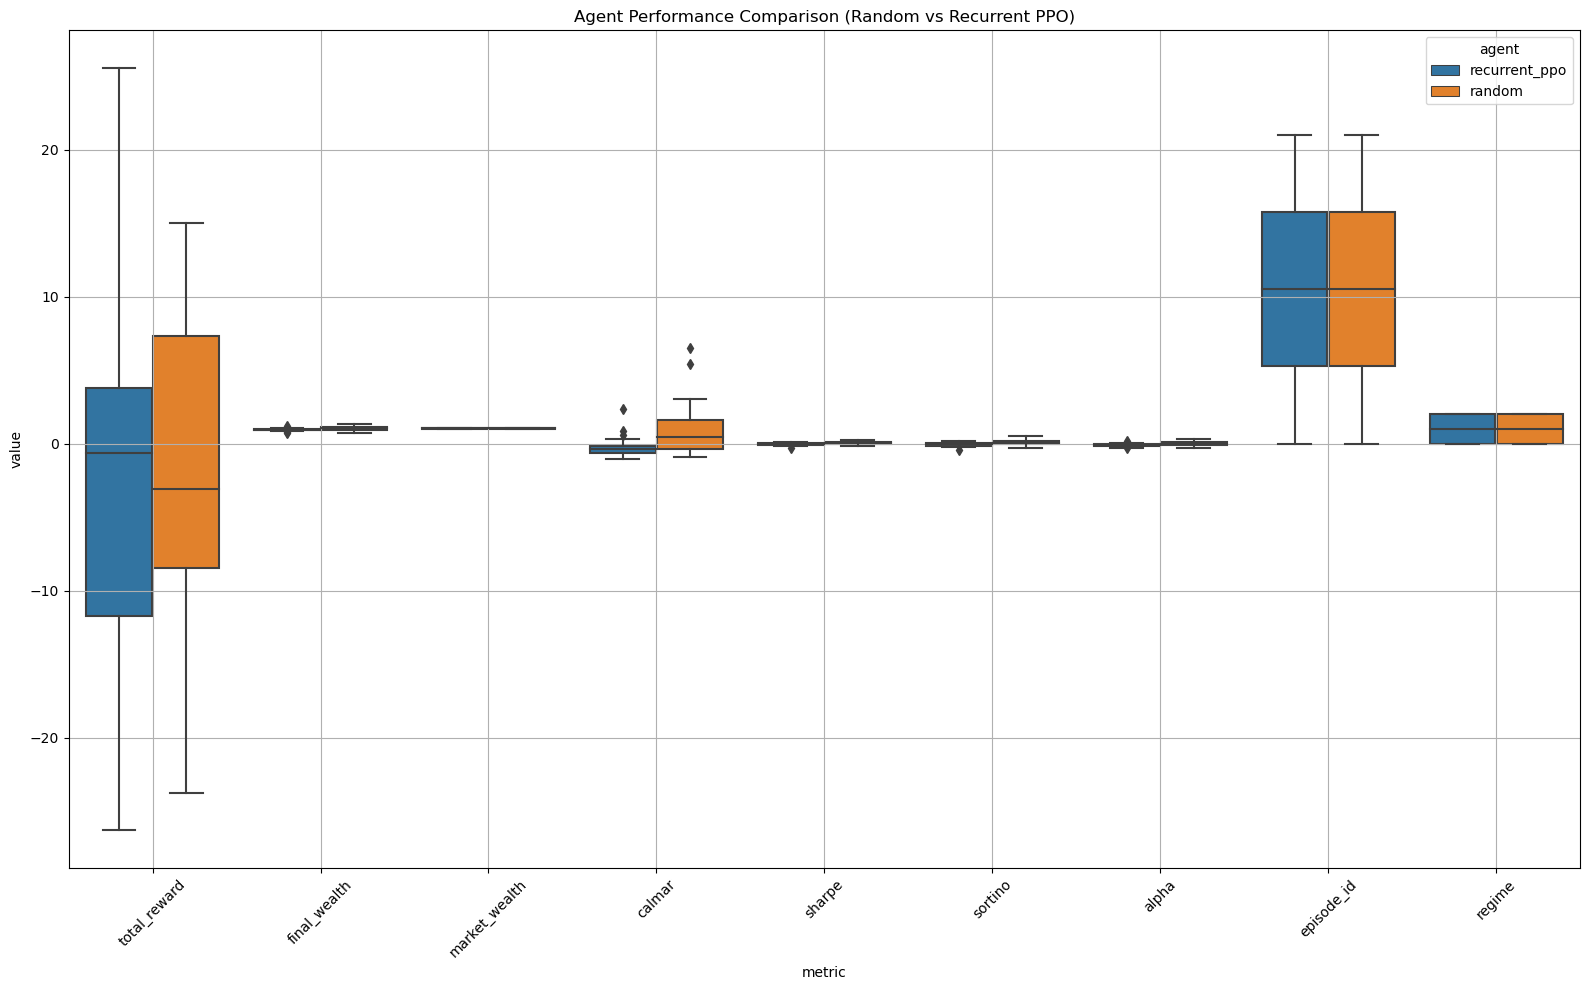

,metric,t-test p-value,mann-whitney p-value
0,total_reward,0.982299,0.934524
1,final_wealth,0.014948,0.019516
2,market_wealth,1.000000,1.000000
3,calmar,0.012800,0.031734
4,sharpe,0.035128,0.107863
5,sortino,0.025932,0.093290
6,alpha,0.016228,0.029915
7,episode_id,1.000000,1.000000
8,regime,1.000000,1.000000


In [232]:
# === Imports ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import ttest_ind, mannwhitneyu

from sb3_contrib import RecurrentPPO
#from src.env.base_timeseries_trading_env import SequenceAwareCumulativeTradingEnv
from src.defaults import TOP2_STOCK_BY_SECTOR, EPISODE_LENGTH
from src.data.feature_pipeline import load_base_dataframe
#from src.env.base_timeseries_trading_env import RegimeAugmentingWrapper

ENV_CLASS=SequenceAwareCumulativeTradingEnv
# === Config ===
N_EVAL_EPISODES = 5
MODEL_PATH = save_path

# === Load Data ===
ohlcv_df = load_base_dataframe()
test_df = ohlcv_df[(ohlcv_df['date'] >= "2023-07-01") & (ohlcv_df['date'] < "2024-01-01")]
test_df = test_df[test_df['symbol'].isin(TOP2_STOCK_BY_SECTOR)]


# === Evaluation Logic ===
def evaluate_agent(agent, env, n_episodes=22):
    episode_metrics = []
    episode_infos = []

    for _ in tqdm(range(n_episodes), desc="Evaluating Agent"):
        obs, _ = env.reset()
        done = False
        state = None
        rewards = []
        infos = []

        # === Tracker setup ===
        tracker = MarketVersusWalletHistoryTracker()
        initial_price = env.env.env.episode_df.iloc[0]['close']
        tracker.reset(initial_price)

        while not done:
            action, state = agent.predict(obs, state=state, deterministic=True)
            action = int(action)
            current_price = env.env.env.episode_df.iloc[env.env.env.current_step]['close']

            # Step the wallet tracker
            tracker.step(action, current_price)

            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)

        # === Episode summary ===
        _env = env.env.env
        agent_wealth = infos[-1].get("final_wealth", np.nan)
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)
        alpha = agent_wealth - market_wealth

        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": agent_wealth,
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha": alpha,
            "episode_id": _env.episode_counter,
            "regime": infos[-1].get("regime", np.nan)
        }

        tracker_data = tracker.export()
        info["ticker"] = _env.episode_df.iloc[0]['symbol']
        info["wallet_history"] = tracker_data["wallet_history"]
        info["market_history"] = tracker_data["market_history"]
        info["market_price_history"] = tracker_data["market_price_history"]
        info["performed_action_history"] = tracker_data["performed_action_history"]
        episode_infos.append(info)
        episode_metrics.append(metrics)

    return pd.DataFrame(episode_metrics), episode_infos

def evaluate_random_agent( env, n_episodes=22):
    episode_metrics = []
    episode_infos = []

    for _ in tqdm(range(n_episodes), desc="Evaluating Agent"):
        obs, _ = env.reset()
        done = False
        state = None
        rewards = []
        infos = []

        # === Tracker setup ===
        tracker = MarketVersusWalletHistoryTracker()
        initial_price = env.env.env.episode_df.iloc[0]['close']
        tracker.reset(initial_price)
        initial_symbol =env.env.env.episode_df.iloc[0]['symbol']
        #print(initial_symbol,env.env.env.episode_df.iloc[0]['date'],len(env.env.env.episode_df),env.env.env.episode_counter,env.env.env.episode_sequence)
        while not done:
            action=  env.action_space.sample()
            action = int(action)
            current_price = env.env.env.episode_df.iloc[env.env.env.current_step]['close']
            current_symbol = env.env.env.episode_df.iloc[env.env.env.current_step]['symbol']
            if(current_symbol != initial_symbol):
                print('EPISODE SWITCHED', initial_symbol,current_symbol)
                initial_symbol = current_symbol
            # Step the wallet tracker
            tracker.step(action, current_price)

            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)
            infos.append(info)
        #print(current_symbol)
        # === Episode summary ===
        _env = env.env.env
        agent_wealth = infos[-1].get("final_wealth", np.nan)
        market_wealth = np.prod(1 + _env.episode_df['market_return_1d'].values)
        alpha = agent_wealth - market_wealth

        metrics = {
            "total_reward": np.sum(rewards),
            "final_wealth": agent_wealth,
            "market_wealth": market_wealth,
            "calmar": infos[-1].get("calmar", np.nan),
            "sharpe": infos[-1].get("episode_sharpe", np.nan),
            "sortino": infos[-1].get("episode_sortino", np.nan),
            "alpha": alpha,
            "episode_id": _env.episode_counter,
            "regime": infos[-1].get("regime", np.nan)
        }

        tracker_data = tracker.export()
        info["ticker"] = _env.episode_df.iloc[0]['symbol']
        info["wallet_history"] = tracker_data["wallet_history"]
        info["market_history"] = tracker_data["market_history"]
        info["market_price_history"] = tracker_data["market_price_history"]
        info["performed_action_history"] = tracker_data["performed_action_history"]
        episode_infos.append(info)
        episode_metrics.append(metrics)

    return pd.DataFrame(episode_metrics), episode_infos


# === Run Evaluation ===

model = RecurrentPPO.load(MODEL_PATH)

def make_test_env():
    eval_env =ENV_CLASS(test_df, episode_length=EPISODE_LENGTH, feature_cols=FEATURE_COLS)
    eval_env.set_episode_sequence(test_seq)
    return PerEpisodeRewardNormalizer(RegimeAugmentingWrapper(eval_env)) #RegimeAugmentingWrapper(ENV_CLASS(test_df, episode_length=EPISODE_LENGTH,feature_cols=FEATURE_COLS))


ppo_agent_df, ppo_agent_infos = evaluate_agent(model, make_test_env(), n_episodes=22)
random_agent_df, random_agent_infos = evaluate_random_agent(make_test_env(), n_episodes=22)

ppo_agent_df["agent"] = "recurrent_ppo"
random_agent_df["agent"] = "random"
results_df = pd.concat([ppo_agent_df, random_agent_df])


# === Plotting ===
melted = results_df.melt(id_vars="agent", var_name="metric", value_name="value")
plt.figure(figsize=(16, 10))
sns.boxplot(data=melted, x="metric", y="value", hue="agent")
plt.title("Agent Performance Comparison (Random vs Recurrent PPO)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# === Statistical Tests ===
comparison_results = []

for metric in ppo_agent_df.columns[:-1]:  # exclude 'agent'
    a = ppo_agent_df[metric].dropna()
    b = random_agent_df[metric].dropna()

    # Skip if either is empty
    if len(a) == 0 or len(b) == 0:
        print(f"Skipping metric {metric}: empty values")
        continue

    t_stat, p_val_t = ttest_ind(a, b)
    u_stat, p_val_u = mannwhitneyu(a, b, alternative='two-sided')
    comparison_results.append({
        "metric": metric,
        "t-test p-value": p_val_t,
        "mann-whitney p-value": p_val_u
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df



In [233]:
make_test_env().env.env.episode_sequence

[('LIN', 4),
 ('SO', 10),
 ('LLY', 11),
 ('JPM', 3),
 ('COST', 2),
 ('NEE', 2),
 ('GE', 11),
 ('UBER', 7),
 ('AMZN', 0),
 ('META', 6),
 ('MSFT', 16),
 ('XOM', 6),
 ('V', 20),
 ('TSLA', 17),
 ('GOOGL', 4),
 ('AMT', 7),
 ('UNH', 16),
 ('CVX', 5),
 ('PLD', 5),
 ('WMT', 2),
 ('SHW', 6),
 ('AAPL', 11)]

<Axes: xlabel='market_wealth', ylabel='alpha'>

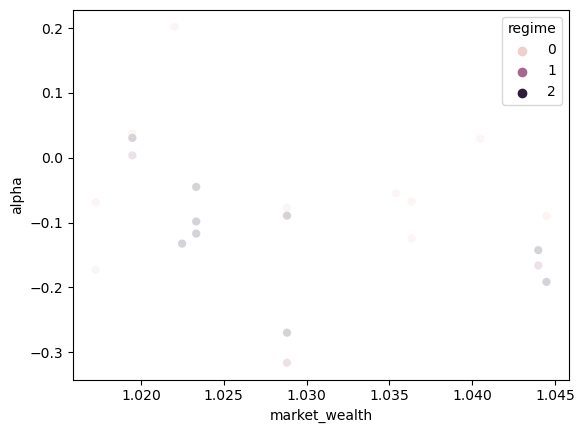

In [237]:
sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='regime', alpha=0.2)

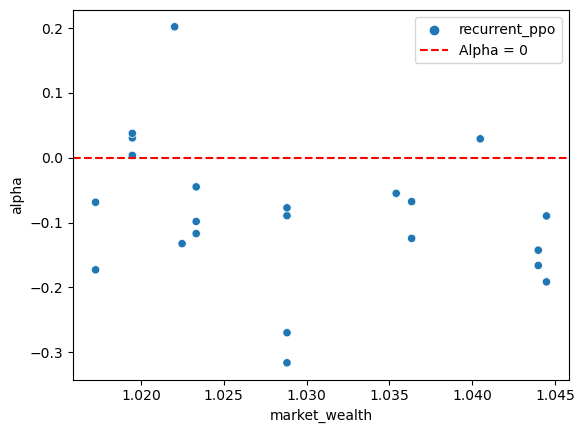

In [238]:

sns.scatterplot(data=ppo_agent_df, x='market_wealth', y='alpha', hue='agent')
plt.axhline(0, linestyle='--', color='red', label='Alpha = 0')
plt.legend()
plt.show()

<Axes: xlabel='agent', ylabel='alpha_ratio'>

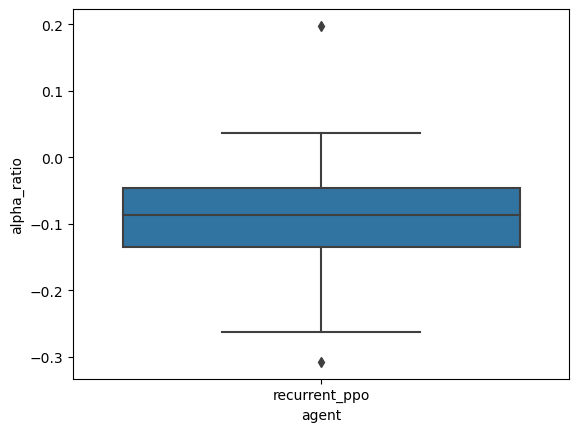

In [239]:
ppo_agent_df['alpha_ratio'] = ppo_agent_df['alpha'] / np.abs(ppo_agent_df['market_wealth'] + 1e-8)
sns.boxplot(data=ppo_agent_df, x='agent', y='alpha_ratio')

In [246]:
episode_complete_results = []
for i in range(len(ppo_agent_infos)):# or select based on alpha, reward, etc.
#for i in range(5):# or select based on alpha, reward, etc.
    info = ppo_agent_infos[i]
    info_ = random_agent_infos[i]
    """
    plt.figure(figsize=(8, 4))
    plt.plot(info['market_history'], label='Market')
    plt.plot(info['wallet_history'], label='Wallet (Agent)')
    plt.plot(info_['wallet_history'], label='Wallet (Random)')
    plt.title(f"Episode {info.get('episode_id')} - {info.get('ticker')}")
    plt.legend()
    plt.grid(True)
    plt.show()
    """
    episode_complete_results.append({
        "agent_wallet":info['wallet_history'][-1],
        "random_wallet":info_['wallet_history'][-1],
        "market_wallet":info_['market_history'][-1],
                                   })
episode_complete_results_df = pd.DataFrame(episode_complete_results)
episode_complete_results_df['agent>random']=episode_complete_results_df['agent_wallet']>episode_complete_results_df['random_wallet']
episode_complete_results_df['agent>market']=episode_complete_results_df['agent_wallet']>episode_complete_results_df['market_wallet']
print("AGENT > RANDOM value counts",episode_complete_results_df['agent>random'].value_counts())
print("AGENT > MARKET value counts",episode_complete_results_df['agent>market'].value_counts())
episode_complete_results_df

AGENT > RANDOM value counts agent>random
False    15
True      7
Name: count, dtype: int64
AGENT > MARKET value counts agent>market
False    18
True      4
Name: count, dtype: int64


,agent_wallet,random_wallet,market_wallet,agent>random,agent>market
0,1.038804,1.026550,1.125752,True,False
1,1.129871,0.899654,1.034882,True,True
2,1.174708,1.203280,1.287680,False,False
3,1.020211,1.098495,1.069142,False,False
4,1.000433,1.204654,1.105384,False,False
5,0.869752,0.996140,0.796494,False,True
6,1.083581,1.196650,1.094549,False,False
7,1.031559,1.119472,1.270158,False,False
8,1.011662,1.030147,1.126862,False,False
9,0.995180,1.169200,1.034525,False,False


In [247]:
from scipy.stats import binom_test

n_wins = episode_complete_results_df['agent>random'].sum()
n_trials = len(episode_complete_results_df)

p_val = binom_test(n_wins, n_trials, p=0.5, alternative='greater')
print(f"PPO wins over Random: {n_wins}/{n_trials}, binomial p-value = {p_val:.4f}")

PPO wins over Random: 7/22, binomial p-value = 0.9738


In [ ]:
w_p_df = pd.DataFrame({"wallet":ppo_agent_infos[0]["wallet_history"],"price":ppo_agent_infos[0]["market_price_history"],"performed_action":ppo_agent_infos[0]["performed_action_history"]})
for i in range(len(w_p_df)):
    print({"i":i,"wallet":w_p_df.iloc[i]["wallet"], "price":w_p_df.iloc[i]["price"], "performed_action":w_p_df.iloc[i]["performed_action"]})

In [ ]:
len(ppo_agent_infos[0]["performed_action_history"]),len(ppo_agent_infos[0]["market_price_history"])